# analysis.ipynb

Author: Gabriel Grand (grandg@mit.edu) | Date: 01-30-23

Preliminary analysis of human results, model, and baselines.

In [1]:
import ast
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, wasserstein_distance

%matplotlib inline

In [2]:
EXPERIMENT_ID = "run-2023-01-30-12-55-36"

FILE_STIMULI = os.path.join("../", "prompting", "data", "stimuli_v1.csv")
FILE_CODEX_RESULTS = os.path.join("../", "experiments", EXPERIMENT_ID, "codex", "results.csv")
FILE_SIMULATOR_RESULTS = os.path.join("../", "experiments", EXPERIMENT_ID, "webppl", "simulator_results.csv")
FILE_HUMAN_DATA = os.path.join("human_data_full.csv")
FILE_BASELINE_ZEROSHOT = os.path.join("../", "experiments", "codex-baseline", "codex_baseline_v1_zeroshot_code-davinci-002_results.csv")

In [3]:
df_stimuli = pd.read_csv(FILE_STIMULI, index_col="task_id", keep_default_na=False)
df_codex = pd.read_csv(FILE_CODEX_RESULTS, index_col="task_id", keep_default_na=False)
df_simulator = pd.read_csv(FILE_SIMULATOR_RESULTS, index_col="task_id", keep_default_na=False)

df_human = pd.read_csv(FILE_HUMAN_DATA, index_col="task_id", keep_default_na=False)
df_human.index = df_human.index.astype(int)
df_human = df_human.rename(axis="columns", mapper={"response": "likert_human"})

df_baseline_zeroshot = pd.read_csv(FILE_BASELINE_ZEROSHOT, index_col="task_id", keep_default_na=False)
df_baseline_zeroshot["probs"] = df_baseline_zeroshot["probs"].apply(ast.literal_eval)

In [4]:
df_human

,run_id,likert_human,complexity,group
task_id,,,,
3,1,5,low,D
6,1,7,low,D
12,1,7,low,D
16,1,4,low,D
18,1,2,medium,D
...,...,...,...,...
46,178,5,high,A
50,178,2,high,A
53,178,3,high,A


In [5]:
df_simulator

,probs,runtime,support,stderr
task_id,,,,
1,"[0.24, 0.62, 0.12000000000000001, 0.0200000000...",26.885068,"[1, 2, 3, 4]",
2,"[0.10000000000000002, 0.38, 0.46, 0.06]",12.462716,"[4, 5, 6, 7]",
3,"[0.06, 0.28, 0.38, 0.26, 0.020000000000000004]",15.920133,"[2, 3, 4, 5, 6]",
4,"[0.06, 0.14, 0.41999999999999993, 0.32, 0.06]",11.967821,"[2, 3, 4, 5, 6]",
5,"[0.06, 0.14, 0.4, 0.36, 0.04000000000000001]",11.704943,"[2, 3, 4, 5, 6]",
...,...,...,...,...
60,"[0.020000000000000004, 0.07999999999999999, 0....",48.414484,"[2, 3, 4, 5, 6, 7]",
61,"[0.07999999999999999, 0.56, 0.36]",22.732293,"[5, 6, 7]",
62,"[0.38, 0.62]",9.453977,"[6, 7]",


In [6]:
N_PARTICIPANTS = 50
data = []

for task_id, row in df_simulator.join(df_stimuli["example_answer"]).iterrows():
    if not row["probs"]:
        print(f"WARNING: No results for task_id {task_id}")
        # data.append({
        #     "task_id": task_id,
        #     "likert_simulator": np.nan,
        #     "example_answer": row["example_answer"]
        # })
        continue
    
    probs = ast.literal_eval(row["probs"])
    support = ast.literal_eval(row["support"])
    
    for p, v in zip(probs, support):
        for _ in range(round(N_PARTICIPANTS * p)):
            data.append({
                "task_id": task_id,
                "likert_simulator": v,
                "example_answer": row["example_answer"]
            })
            
df_simulator = pd.DataFrame(data)
df_simulator

,task_id,likert_simulator,example_answer
0,1,1,2
1,1,1,2
2,1,1,2
3,1,1,2
4,1,1,2
...,...,...,...
3195,64,4,3
3196,64,4,3
3197,64,4,3
3198,64,4,3


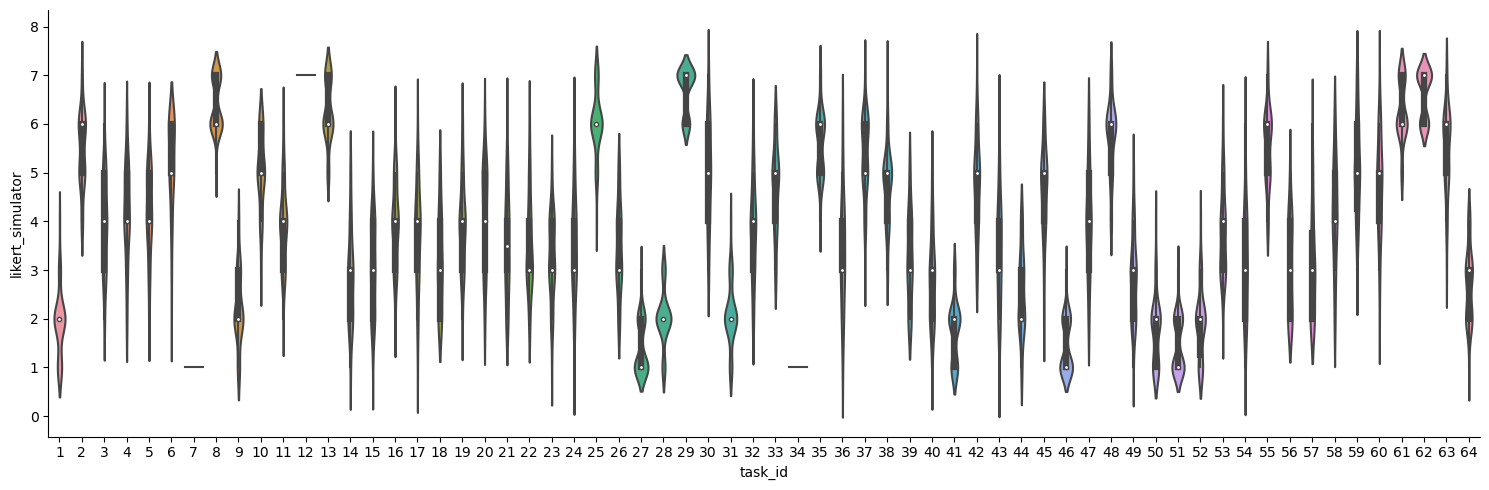

In [7]:
sns.catplot(data=df_simulator, x="task_id", y="likert_simulator", kind="violin", aspect=3)

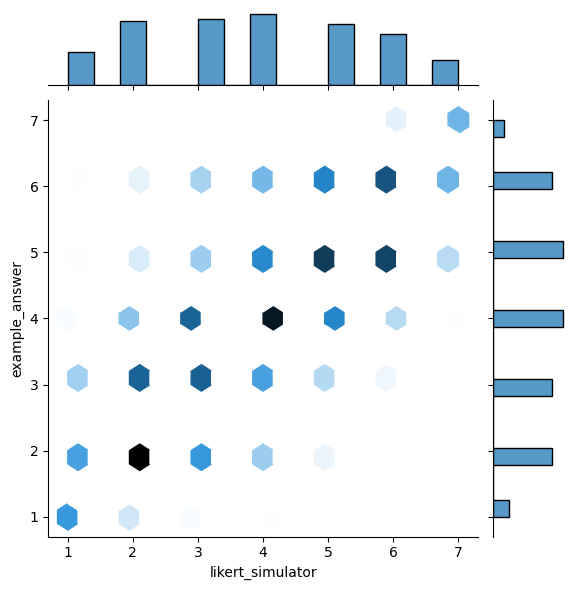

In [8]:
sns.jointplot(data=df_simulator, x="likert_simulator", y="example_answer", kind="hex")

<AxesSubplot: xlabel='likert_simulator', ylabel='example_answer'>

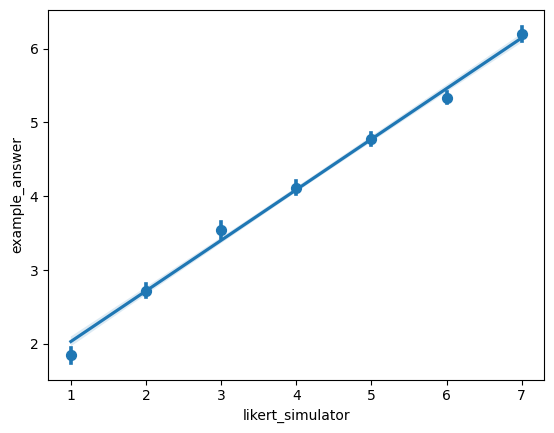

In [9]:
sns.regplot(data=df_simulator, x="likert_simulator", y="example_answer", x_estimator=np.mean)

## Model vs. human comparisons by taking mean

In [10]:
df_human_mean = df_human.groupby("task_id").mean("likert_human")
df_human_mean

,run_id,likert_human
task_id,,
1,85.666667,1.952381
2,92.600000,5.400000
3,89.000000,4.026316
4,92.700000,3.475000
5,92.700000,3.975000
...,...,...
60,85.666667,4.547619
61,89.000000,5.605263
62,92.600000,6.250000


In [11]:
df_simulator_mean = df_simulator.groupby("task_id").mean("likert")
df_human_mean = df_human.groupby("task_id").mean("likert_human")
df_comparison = df_simulator_mean.join(df_human_mean[["likert_human"]], how="inner")
df_comparison.to_csv("comparison_simulator_human.csv")

In [12]:
rho, pval = pearsonr(df_comparison["likert_simulator"].tolist(), df_comparison["likert_human"].tolist())
print(rho, pval)
print(rho ** 2)

0.8683157486799128 1.5262836217069925e-20
0.7539722394055575


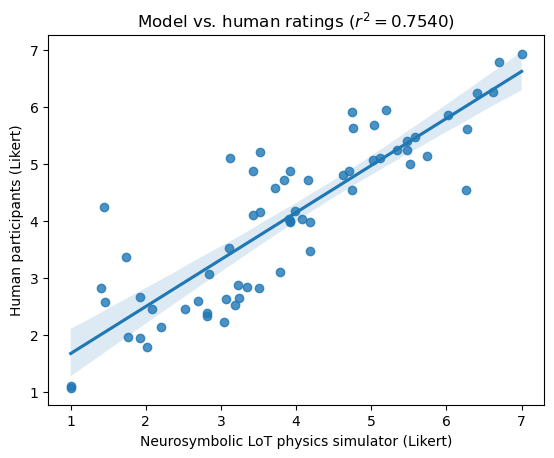

In [13]:
sns.regplot(data=df_comparison, x="likert_simulator", y="likert_human")
plt.xlabel("Neurosymbolic LoT physics simulator (Likert)")
plt.ylabel("Human participants (Likert)")
plt.title(fr"Model vs. human ratings ($r^2={(rho ** 2):.04f}$)")
plt.savefig(f"physlang_model_human_results.png", dpi=300)

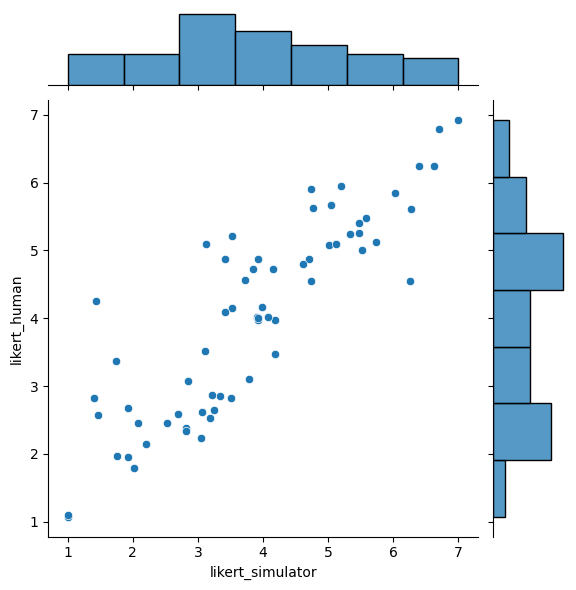

In [14]:
sns.jointplot(data=df_comparison, x="likert_simulator", y="likert_human")

In [15]:
def transform_probs_to_likert(probs):
    return np.dot(probs, np.array([1, 2, 3, 4, 5, 6, 7]))

df_baseline_zeroshot["likert_baseline_zeroshot"] = df_baseline_zeroshot["probs"].apply(transform_probs_to_likert)

In [16]:
df_baseline_zeroshot

,probs,runtime,support,likert_baseline_zeroshot
task_id,,,,
1,"[0.3726015459939108, 0.07394167822455831, 0.07...",,"[1, 2, 3, 4, 5, 6, 7]",3.406778
2,"[0.27126980171626264, 0.11686123624309944, 0.1...",,"[1, 2, 3, 4, 5, 6, 7]",3.672502
3,"[0.3161613933330072, 0.11094727124287544, 0.12...",,"[1, 2, 3, 4, 5, 6, 7]",3.483171
4,"[0.31571144747861274, 0.07093048475964306, 0.0...",,"[1, 2, 3, 4, 5, 6, 7]",3.913468
5,"[0.30302023575124354, 0.07307836393448895, 0.1...",,"[1, 2, 3, 4, 5, 6, 7]",3.930708
...,...,...,...,...
60,"[0.33842078124559705, 0.08721028242200751, 0.1...",,"[1, 2, 3, 4, 5, 6, 7]",3.680793
61,"[0.25272041379536847, 0.09996411092880021, 0.1...",,"[1, 2, 3, 4, 5, 6, 7]",3.963240
62,"[0.30726091485419876, 0.07941196186817145, 0.1...",,"[1, 2, 3, 4, 5, 6, 7]",3.918334


<AxesSubplot: >

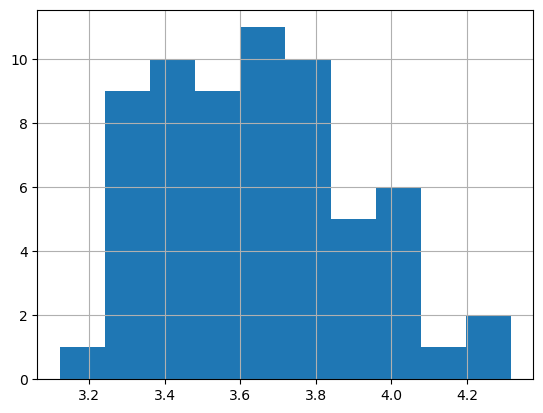

In [17]:
df_baseline_zeroshot["likert_baseline_zeroshot"].hist()

<AxesSubplot: xlabel='likert_baseline_zeroshot', ylabel='likert_human'>

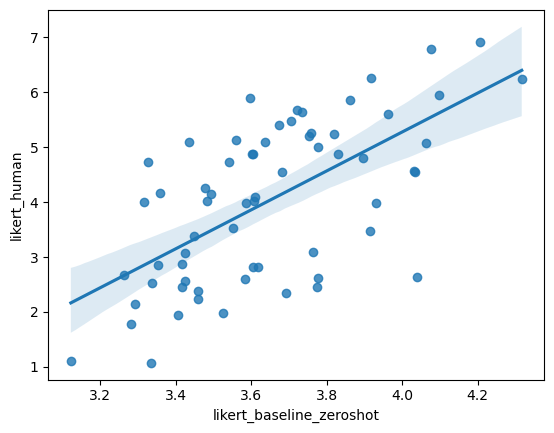

In [18]:
df_comparison_baseline = df_baseline_zeroshot.join(df_human_mean[["likert_human"]], how="inner")
sns.regplot(data=df_comparison_baseline, x="likert_baseline_zeroshot", y="likert_human")

In [19]:
rho, pval = pearsonr(df_comparison_baseline["likert_baseline_zeroshot"].tolist(), df_comparison_baseline["likert_human"].tolist())
print(rho, pval)
print(rho ** 2)

0.6334560680660787 1.9359984756161116e-08
0.4012665901697365


## Wasserstein analysis (wide)

In [20]:
def tall_to_wide(df, likert_col: str = "likert"):

    data = []
    for task_id, df_group in df.groupby("task_id"):

        value_counts = {likert_value: 0.0 for likert_value in [1, 2, 3, 4, 5, 6, 7]}
        for likert_value, weight in df_group[likert_col].value_counts(normalize=True).sort_index().items():
            value_counts[likert_value] = weight
        likert_weights = list(value_counts.values())

        data.append({
            "task_id": task_id,
            "likert_weights": likert_weights,
        })

    df_wide = pd.DataFrame(data)
    assert np.allclose(df_wide["likert_weights"].apply(sum), 1.0)
    return df_wide

In [21]:
df_human_wide = tall_to_wide(df_human, likert_col="likert_human")
df_human_wide["source"] = "human"
df_human_wide

,task_id,likert_weights,source
0,1,"[0.23809523809523808, 0.6190476190476191, 0.11...",human
1,2,"[0.0, 0.0, 0.025, 0.075, 0.45, 0.375, 0.075]",human
2,3,"[0.0, 0.0, 0.0, 0.9736842105263158, 0.02631578...",human
3,4,"[0.025, 0.2, 0.15, 0.55, 0.05, 0.025, 0.0]",human
4,5,"[0.0, 0.0, 0.05, 0.925, 0.025, 0.0, 0.0]",human
...,...,...,...
59,60,"[0.0, 0.023809523809523808, 0.1904761904761904...",human
60,61,"[0.0, 0.02631578947368421, 0.0, 0.026315789473...",human
61,62,"[0.0, 0.025, 0.0, 0.0, 0.175, 0.275, 0.525]",human
62,63,"[0.0, 0.025, 0.075, 0.0, 0.5, 0.325, 0.075]",human


In [22]:
df_simulator_wide = tall_to_wide(df_simulator, likert_col="likert_simulator")
df_simulator_wide["source"] = "simulator"
df_simulator_wide

,task_id,likert_weights,source
0,1,"[0.24, 0.62, 0.12, 0.02, 0.0, 0.0, 0.0]",simulator
1,2,"[0.0, 0.0, 0.0, 0.1, 0.38, 0.46, 0.06]",simulator
2,3,"[0.0, 0.06, 0.28, 0.38, 0.26, 0.02, 0.0]",simulator
3,4,"[0.0, 0.06, 0.14, 0.42, 0.32, 0.06, 0.0]",simulator
4,5,"[0.0, 0.06, 0.14, 0.4, 0.36, 0.04, 0.0]",simulator
...,...,...,...
59,60,"[0.0, 0.02, 0.08, 0.28, 0.4, 0.2, 0.02]",simulator
60,61,"[0.0, 0.0, 0.0, 0.0, 0.08, 0.56, 0.36]",simulator
61,62,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.38, 0.62]",simulator
62,63,"[0.0, 0.0, 0.02, 0.1, 0.32, 0.5, 0.06]",simulator


In [23]:
df_baseline_zeroshot_wide = df_baseline_zeroshot[["probs"]].rename({"probs": "likert_weights"}, axis="columns").reset_index()
assert np.allclose(df_baseline_zeroshot_wide["likert_weights"].apply(sum), 1.0)
df_baseline_zeroshot_wide["source"] = "baseline_zeroshot"
df_baseline_zeroshot_wide

,task_id,likert_weights,source
0,1,"[0.3726015459939108, 0.07394167822455831, 0.07...",baseline_zeroshot
1,2,"[0.27126980171626264, 0.11686123624309944, 0.1...",baseline_zeroshot
2,3,"[0.3161613933330072, 0.11094727124287544, 0.12...",baseline_zeroshot
3,4,"[0.31571144747861274, 0.07093048475964306, 0.0...",baseline_zeroshot
4,5,"[0.30302023575124354, 0.07307836393448895, 0.1...",baseline_zeroshot
...,...,...,...
59,60,"[0.33842078124559705, 0.08721028242200751, 0.1...",baseline_zeroshot
60,61,"[0.25272041379536847, 0.09996411092880021, 0.1...",baseline_zeroshot
61,62,"[0.30726091485419876, 0.07941196186817145, 0.1...",baseline_zeroshot
62,63,"[0.2588691617197997, 0.10320107296639708, 0.14...",baseline_zeroshot


In [24]:
df_comparison_wide = pd.concat([df_human_wide, df_simulator_wide, df_baseline_zeroshot_wide]).sort_values("task_id").reset_index(drop=True)
df_comparison_wide

,task_id,likert_weights,source
0,1,"[0.23809523809523808, 0.6190476190476191, 0.11...",human
1,1,"[0.24, 0.62, 0.12, 0.02, 0.0, 0.0, 0.0]",simulator
2,1,"[0.3726015459939108, 0.07394167822455831, 0.07...",baseline_zeroshot
3,2,"[0.0, 0.0, 0.025, 0.075, 0.45, 0.375, 0.075]",human
4,2,"[0.0, 0.0, 0.0, 0.1, 0.38, 0.46, 0.06]",simulator
...,...,...,...
187,63,"[0.0, 0.025, 0.075, 0.0, 0.5, 0.325, 0.075]",human
188,63,"[0.0, 0.0, 0.02, 0.1, 0.32, 0.5, 0.06]",simulator
189,64,"[0.02, 0.4, 0.44, 0.14, 0.0, 0.0, 0.0]",simulator
190,64,"[0.09523809523809523, 0.42857142857142855, 0.3...",human


In [25]:
data = []

for task_id, df_group in df_comparison_wide.groupby("task_id"):
    
    likert = [1, 2, 3, 4, 5, 6, 7]
    
    likert_weights_human = df_group[df_group["source"] == "human"]["likert_weights"].item()
    likert_weights_simulator = df_group[df_group["source"] == "simulator"]["likert_weights"].item()
    likert_weights_baseline_zeroshot = df_group[df_group["source"] == "baseline_zeroshot"]["likert_weights"].item()
    
    wd_human_simulator = wasserstein_distance(likert, likert, likert_weights_human, likert_weights_simulator)
    wd_human_baseline_zeroshot = wasserstein_distance(likert, likert, likert_weights_human, likert_weights_baseline_zeroshot)
    
    data.append(
        {
            "task_id": task_id,
            "wd_human_simulator": wd_human_simulator,
            "wd_human_baseline_zeroshot": wd_human_baseline_zeroshot,
        }
    )
    
df_wd = pd.DataFrame(data).set_index("task_id")

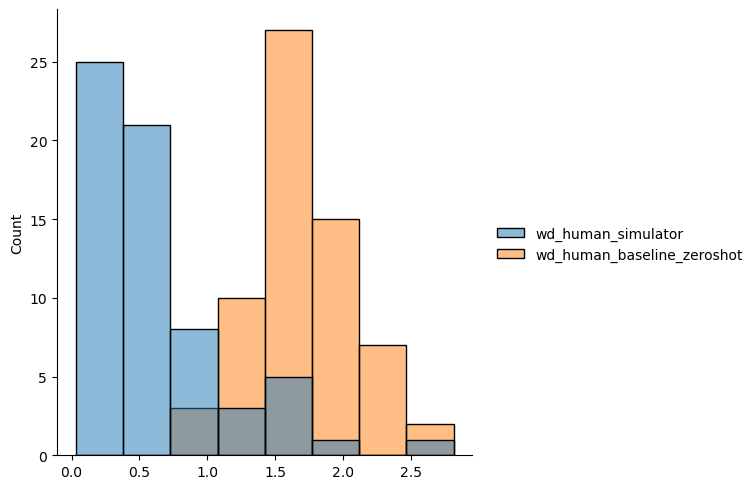

In [26]:
sns.displot(data=df_wd)

## Wasserstein analysis (tall)
NOTE: This is incorrect for the baseline because it uses the averaged likert values for Codex. Use the Wasserstein wide analysis above.

In [27]:
df_human_tall = df_human.drop(["run_id", "complexity", "group"], axis="columns").reset_index()
df_human_tall = df_human_tall.rename({"likert_human": "likert"}, axis="columns")
df_human_tall["source"] = "human"
df_human_tall

,task_id,likert,source
0,3,5,human
1,6,7,human
2,12,7,human
3,16,4,human
4,18,2,human
...,...,...,...
2555,46,5,human
2556,50,2,human
2557,53,3,human
2558,59,6,human


In [28]:
df_simulator_tall = df_simulator.drop("example_answer", axis="columns").reset_index(drop=True)
df_simulator_tall = df_simulator_tall.rename({"likert_simulator": "likert"}, axis="columns")
df_simulator_tall["source"] = "simulator"
df_simulator_tall

,task_id,likert,source
0,1,1,simulator
1,1,1,simulator
2,1,1,simulator
3,1,1,simulator
4,1,1,simulator
...,...,...,...
3195,64,4,simulator
3196,64,4,simulator
3197,64,4,simulator
3198,64,4,simulator


In [29]:
df_baseline_zeroshot_tall = df_baseline_zeroshot[["likert_baseline_zeroshot"]].reset_index()
df_baseline_zeroshot_tall = df_baseline_zeroshot_tall.rename({"likert_baseline_zeroshot": "likert"}, axis="columns")
df_baseline_zeroshot_tall["source"] = "baseline_zeroshot"
df_baseline_zeroshot_tall

,task_id,likert,source
0,1,3.406778,baseline_zeroshot
1,2,3.672502,baseline_zeroshot
2,3,3.483171,baseline_zeroshot
3,4,3.913468,baseline_zeroshot
4,5,3.930708,baseline_zeroshot
...,...,...,...
59,60,3.680793,baseline_zeroshot
60,61,3.963240,baseline_zeroshot
61,62,3.918334,baseline_zeroshot
62,63,3.759113,baseline_zeroshot


In [30]:
df_comparison_tall = pd.concat([df_human_tall, df_simulator_tall, df_baseline_zeroshot_tall]).sort_values("task_id").reset_index(drop=True)
df_comparison_tall

,task_id,likert,source
0,1,2.000000,simulator
1,1,1.000000,simulator
2,1,1.000000,simulator
3,1,1.000000,simulator
4,1,2.000000,simulator
...,...,...,...
5819,64,3.000000,simulator
5820,64,3.000000,simulator
5821,64,3.000000,simulator
5822,64,3.000000,simulator


In [31]:
data = []

for task_id, df_group in df_comparison_tall.groupby("task_id"):
    
    likert_human = df_group[df_group["source"] == "human"]["likert"].tolist()
    likert_simulator = df_group[df_group["source"] == "simulator"]["likert"].tolist()
    likert_baseline_zeroshot = df_group[df_group["source"] == "baseline_zeroshot"]["likert"].tolist()
    
    wd_human_simulator = wasserstein_distance(likert_human, likert_simulator)
    wd_human_baseline_zeroshot = wasserstein_distance(likert_human, likert_baseline_zeroshot)
    
    data.append(
        {
            "task_id": task_id,
            "wd_human_simulator": wd_human_simulator,
            "wd_human_baseline_zeroshot": wd_human_baseline_zeroshot,
        }
    )
    
df_wd = pd.DataFrame(data).set_index("task_id")